<font size="4">**Institution:** *Athens University of Economics and Business*</font><br/>
<font size="4">**Department:** *School of Sciences and Technology*</font><br/>
<font size="4">**Post Graduate Program:** *MSc in Data Science*</font><br/>
<font size="4">**Course:** *Optimization Techniques (FT)*</font><br/>
<font size="4">**Assignment No:** *2*</font><br/>
<font size="4">**Title:** *SVMs - Sequential Minimal Optimization (SMO) Implementation*</font><br/><br/>
<font size="4">**Student:** *Vyzaniaris Georgios*</font><br/>
<font size="4">**Registration No:** *f3352203*</font><br/>
<font size="4">**e-mail:** gvizaniaris@aueb.gr</font><br/><br/>

[PART 0](#part0)
* [Libraries](#li)
* [User's Defined Variables](#udv)
* [Obtain Data](#od)


[PART A](#parta) (SMO Formulation)

[PART B](#partb) (SMO Implementation & Tuning)
* [Base Implementation over the Training Set](#partb1)
* [Hyper-parameter Tuning](#partb2)
* [Tuned Classifier Implementation](#partb3)

[PART C](#partc) (SMO Performance wrt Training Size)<br/><br/>

#### <u>References<u/>
* <a href='https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf'>Sequential Minimal Optimization (SMO): A Fast Algorithm for Training SVMs</a>
* <a href='https://sgfin.github.io/files/notes/CS229_Lecture_Notes.pdf'>CS229 Lecture notes by Andrew Ng</a>




<a name="part0"></a>
# <font color='green'>**PART 0**

<a name="li"></a>
>## **Libraries**

In [ ]:
!pip install wget --q

  Preparing metadata (setup.py) ... done


In [ ]:
# general
import os
import glob
import wget
import time
import math
import random
import numpy as np
from tqdm import tqdm

# loading the dataset
from sklearn.datasets import load_svmlight_files

# custom classifier construction, evaluation & hyper-parameter tuning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.model_selection import learning_curve, LearningCurveDisplay
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

# graphics
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

<a name="udv"></a>
>## **User-Defined Variables**

In [ ]:
# the URLs from which we're going to download the gisette dataset
urls = ['https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/gisette_scale.bz2',
      'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/gisette_scale.t.bz2']

<a name="od"></a>
>## **Obtain Data**

In [ ]:
def getData(urls):
  '''
  USAGE :  to retrieve the dataset from a given URL
  TODO  :
          1.  iterate through the given URL
          2.  extract the train and test sets
          3.  remove unnecessary files from the directory
          4.  return train and test sets to the user
  INPUT :
          URLs    : the URL addresses of the dataset
  OUTPUT:
          X_train : the examples to train the classifier
          y_train : the ground truth of the examples
          X_test  : the examples for testing the classifier
          y_test  : the labels of the test-set
  '''

  # iterating the URLs to download the dataset, specifying the destination folder to place it
  for url in tqdm(urls):
    wget.download(url, '/content')

  # extracting our data from the files we downloaded
  X_train, y_train, X_test, y_test = load_svmlight_files(('/content/' + urls[0].split('/')[-1],
                                                          '/content/' + urls[1].split('/')[-1]))

  X_train, y_train, X_test, y_test = X_train.A, np.array(y_train), X_test.A, np.array(y_test)

  # scaling our data for better computational performance
  # the dataset is already normalized as it's stated from the contributor, so we don't need to perform such action
  scaler = StandardScaler()
  model1 = scaler.fit(X_train)
  model2 = scaler.fit(X_test)
  X_train = model1.transform(X_train)
  X_test = model2.transform(X_test)

  # looking through the shapes of X_train/test sets (m-examples, n-features)
  # & y_train/test labels (m-examples, 1)
  print(f'The shape of X_train: {X_train.shape}')
  print(f'The shape of y_train: {y_train.shape}')
  print(f'The shape of X_test: {X_test.shape}')
  print(f'The shape of y_test: {y_test.shape}')

  # deleting unnecessary files
  for f in glob.glob('/content/*.bz2'):
    os.remove(f)

  return X_train, y_train, X_test, y_test

In [ ]:
def FreqPlot(t1, t2):
  '''
  USAGE:  to create and present the freq distribution of the train & test outputs
  TODO:
        1.  compute the frequencies
        2.  setup the workspace
        3.  create the barplots
        4.  present the plots to the user
  INPUT:
        t1 : the y_train
        t2 : the y_test
  OUTPUT:
        a bar plot presenting the distribution in train and test sets
  '''
  #******************************************************
  #******************** COUNTING ************************
  #******************************************************

  #------------------- train set ------------------------
  unique0, count0 = np.unique(t1, return_counts=True)
  h1 = np.asarray((unique0, count0))

  #-------------------- test set ------------------------
  unique1, count1 = np.unique(t2, return_counts=True)
  h2 = np.asarray((unique1, count1))

  #******************************************************
  #******************** PLOTING *************************
  #******************************************************
  X_axis = np.arange(len(unique0))
  plt.style.use('seaborn')
  #------------------- train set ------------------------
  h1 = plt.bar(X_axis - 0.2, count0, 0.4, label = 'Train')
  plt.bar_label(h1, padding=1)
  #-------------------- test set ------------------------
  h2 = plt.bar(X_axis + 0.2, count1, 0.4, label = 'Test')
  plt.bar_label(h2, padding=1)

  #----------------- refining plot ----------------------
  plt.xticks(X_axis, unique0)
  plt.xlabel("\nClasses")
  plt.ylabel("Frequences\n")
  plt.title("Frequences in each Class\n", fontsize=20)

  plt.legend()
  plt.show()

In [ ]:
# retrieving the data from the source
X_train, y_train, X_test, y_test = getData(urls)

100%|██████████| 2/2 [00:06<00:00,  3.34s/it]


The shape of X_train: (6000, 5000)
The shape of y_train: (6000,)
The shape of X_test: (1000, 5000)
The shape of y_test: (1000,)


<ipython-input-5-e308b3c05b2d>:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


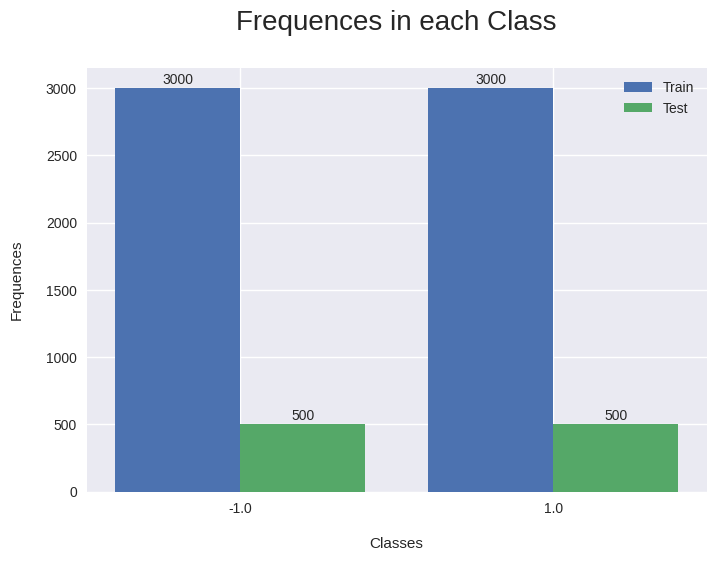

In [ ]:
# displaying the frequency of our dataset wrt train & test sets
FreqPlot(y_train, y_test)

As we can observe, it's a `balanced dataset`

<a name="parta"></a>
# <font color='orange'>**PART A**</font> (SMO Formulation)

In [ ]:
class SMO(ClassifierMixin, BaseEstimator):
  '''
  USAGE: the use of this class is to define the SMO classifier along with
          its methods needed for the cause
  METHODS:
          1.  __init__  : classifier's constructor
          2.  fit       : fitting our X, y training data to our model
          3.  predict   : make predictions for testing examples
  '''

  #*************************************************************************************
  #---------------------------------- HELPER FUNCTIONS ---------------------------------
  #*************************************************************************************
  '''
  USAGE : to assist methods fit(...) & predict(...) to fulfill their purpose
  '''
  def linear_kernel(self, x1,x2):
    return np.inner(x1, x2)

  # the objective func as it presented in the technical doc (eq.11)
  def objective_function(self, alphas, y, kernel, X):
    return np.sum(alphas) - 0.5 * np.sum((y[:, None] * y[None, :]) * kernel(X, X) * (alphas[:, None] * alphas[None, :]))

  # the decision func as it presented in the technical doc (eq.10)
  def decision_function(self, alphas, y, kernel, X, x, b):
    result = (alphas * y) @ kernel(X, x) - b
    return result

  #*************************************************************************************
  #------------------------------------ CONSTRUCTOR ------------------------------------
  #*************************************************************************************
  '''
  # the constructor takes notes relating to specific parameters once the classifier is
  # implemented using **kwargs(keywords)
  '''
  def __init__(self, C=1.0, tol=0.01, eps=0.01, max_iter=30):
    '''
    USAGE : to instantiate the classifier
    TODO  :
    INPUT :
      **kwargs  :  hyper-parameters used to instatiate the classifier (using pre-defined variables):
                    max_iter  : max number of iterations our classifier may conduct
                    tol:  error tolerance
                    eps : alphas' accuaracy for computing the lagrange multipliers
                    C : regularization parameter of the SOM's objective function. The constant C
                        controls weighting between our goal of making the margin large and ensuring
                        that most of the examples have a functional margin of at least 1.0.
                        The constant C is an argument to our optimization code that we can tune
                        and get different results
    OUTPUT:
      an instance of a binary classifier (SOM)
    '''
    self.C = C
    self.tol = tol
    self.eps = eps
    self.max_iter = max_iter

  #*************************************************************************************
  #----------------------------------------- FIT ---------------------------------------
  #*************************************************************************************
  def fit(self, X, y):
    '''
    USAGE: A reference implementation of a fitting function for the classifier
    TODO:  implementing the given J.C.Platt algorithm as it presented in the technical report
    INPUT:
      X : array-like, shape (m_samples, n_features). The training input samples.
      y : array-like, shape (m_samples,). The target values. An array of int
    OUTPUT:
      the classifier as an object
    '''
    # >>>>> classifier's cashe memory <<<<<
    # checking X, y for appropriate shape
    X, y = check_X_y(X, y)
    self.is_fitted_ = True
    # Store the classes seen during fit
    self.classes_ = unique_labels(y)
    # setting parameters
    self.b = 0                                              # bias factor (intercept)
    self.X_ = X                                             # the examples
    self.y_ = y                                             # the ground truth
    self.m_, self.n_ = self.X_.shape[0], self.X_.shape[1]   # example's dim
    self.alphas = np.zeros(self.m_)                         # lagrange multipliers
    self.kernel = self.linear_kernel                        # kernel used (linear)
    self.errors_ = self.decision_function(self.alphas, self.y_, self.kernel,  self.X_ , self.X_ , self.b) - self.y_ # initializing the errors

    np.random.seed(0)

    #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> PLATT'S ALGORITHM <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    #************************************ takeStep ***************************************
    def takeStep(i1, i2):
      # making sure we choose different alphas...ff the alphas are the same -> skip step
      # positive progress cannot be made if the first and second training examples share identical input vectors x
      if i1 == i2:
        return 0

      # Extraction of the variables from the cache
      alph1 = self.alphas[i1]
      alph2 = self.alphas[i2]
      y1 = self.y_[i1]
      y2 = self.y_[i2]
      E1 = self.errors_[i1]
      E2 = self.errors_[i2]

      s = y1 * y2

      # >>>>> computing the bounds L & H (eq.13-14) <<<<<
      # depending on the value of the labels y1 & y2 we calculate the upper and lower bounds L & H
      if y1 == y2:
        L = max(0 , alph1 + alph2 - self.C)
        H = min(self.C, alph1 + alph2)
      else:
        L = max(0, alph2 - alph1)
        H = min(self.C, self.C + alph2 - alph1)

      # if lower and the upper bounds L & H are the same -> skip step
      if L == H:
        return 0

      # >>>>> computing eta (eq.15) <<<<<
      #Compute the kernels for the two selected examples (support computations for eta variable)
      k11 = self.kernel(self.X_[i1], self.X_[i1])
      k12 = self.kernel(self.X_[i1], self.X_[i2])
      k22 = self.kernel(self.X_[i2], self.X_[i2])

      # compute eta
      eta = k11 + k22 - 2 * k12

      # >>>>> compute alphas (eq.16-17) <<<<<
      # if eta > 0 -> compute a2 as function of the old a2
      if eta > 0:
        a2 = alph2 + (y2 * (E1 - E2)) / eta

        # clipping a2 wrt the bounds L & H
        if a2 <= L:
          a2 = L
        elif a2 >= H:
          a2 = H
        else:
          a2 = a2
      else:
        # getting copies of alphas we don't want to chahge the original alphas values,
        # we want to compute only the different objective functions for a2.
        alphas_adj = self.alphas.copy()

        alphas_adj[i2] = L
        Lobj = self.objective_function(alphas_adj, self.y_, self.kernel, self.X_) # Objective function at a2=L

        alphas_adj[i2] = H
        Hobj = self.objective_function(alphas_adj, self.y_, self.kernel, self.X_) # Objective function at a2=H

        # clipping a2 as mentioned in the technical report
        if Lobj < (Hobj - self.eps):
          a2 = L
        elif Lobj > (Hobj + self.eps):
          a2 = H
        else:
          a2 = alph2

      # if a2 value is very small - enter a value of 0
      if a2 < 1e-8:
        a2 = 0.0
      elif a2 > (self.C - 1e-8):
        a2 = self.C

      #Skip this step if the change in a2 is less than *eps(a2_new + a2_old + eps)
      if np.abs(a2 - alph2) < (self.eps * (a2 + alph2 + self.eps)):
        return 0

      # compute a1 as a function of the old a1, a2 and s (eq.18)
      a1 = alph1 + s * (alph2 - a2)

      # >>>>> computing the possible bias (threshold) values (eq.20-21) <<<<<
      b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + self.b      # eq.20
      b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + self.b      # eq.21

      # update the bias (threshold) value according to the alpha (a1,a2) values found
      # if alphas are not at bounds
      if 0 < a1 and a1 < self.C:
        b = b1
      elif 0 < a2 and a2 < self.C:
        b = b2
      else: # if both alphas are at bound
        b = (b1 + b2) * 0.5

      # >>>>> cashe updates <<<<<

      # update alphas found
      self.alphas[i1] = a1
      self.alphas[i2] = a2

      # update error cache -> 0 if a1 ,a2 are in bounds
      for index, alph in zip([i1, i2], [a1, a2]):
        if (0.0 < alph) and (alph < self.C):
          self.errors_[index] = 0.0

      # update error cache for the rest alphas (lagrange multipliers)
      Not_a1_a2 = [n for n in range(self.m_) if (n != i1 and n != i2)]
      self.errors_[Not_a1_a2] = self.errors_[Not_a1_a2] + y1 * (a1 - alph1) * self.kernel(self.X_[i1], self.X_[Not_a1_a2]) + y2 * (a2 - alph2) * self.kernel(self.X_[i2], self.X_[Not_a1_a2]) + self.b - b

      # update bias (threshold) found
      self.b = b

      return 1

    #********************************** examineExample *************************************
    def examineExample(i2):
      y2 = self.y_[i2]
      alph2 = self.alphas[i2]
      E2 = self.errors_[i2]
      r2 = E2 * y2

      # proceed if error is within the specified tolerance (tol)
      if ((r2 < -self.tol and alph2 < self.C) or (r2 > self.tol and alph2 > 0)):

        # if (number of non-zero & non-C alpha > 1)
        if len(self.alphas[(self.alphas != 0) & (self.alphas != self.C)]) > 1:

          # 2nd choice heuristic usage. choose an error to approximately maximize the step size
          if self.errors_[i2] > 0:
            i1 = np.argmin(self.errors_)
          elif self.errors_[i2] <= 0:
            i1 = np.argmax(self.errors_)

          step = takeStep(i1, i2)

          if step:
            return 1

        # loop over all non-zero and non-C alpha, starting at a random point
        for i1 in np.roll(np.where((self.alphas != 0) & (self.alphas != self.C))[0], np.random.choice(np.arange(self.m_))):
          step = takeStep(i1, i2)
          if step:
            return 1

        # loop over all possible i1, starting at a random point
        for i1 in np.roll(np.arange(self.m_), np.random.choice(np.arange(self.m_))):
          step = takeStep(i1, i2)
          if step:
            return 1

      return 0

    #*********************************** driver func ***************************************
    numChanged = 0
    examineAll = 1
    iter = 0

    while ((numChanged > 0 or examineAll) and (iter < self.max_iter)):
      start = time.time()
      iter += 1
      numChanged = 0

      if examineAll:
        for i in range(self.m_):
          res = examineExample(i)
          numChanged += res
      else:
        for i in np.where((self.alphas != 0) & (self.alphas != self.C))[0]:
          res = examineExample(i)
          numChanged += res

      if examineAll == 1:
        examineAll = 0
      elif numChanged == 0:
        examineAll = 1

      end = time.time()
      total = end - start

    return self

  #*************************************************************************************
  #--------------------------------------- PREDICT -------------------------------------
  #*************************************************************************************
  def predict(self, X):
    '''
    USAGE : to predict in which class an example belongs to
    TODO  : 1.  check if fit method has been invoked
            2.  check if the example has the proper dim
            3.  iterate through the examples and predict

    INPUT :
            X : array-like, shape (n_samples, n_features). The input test sample
    OUTPUT:
            y : ndarray, shape (n_samples,). The label for each sample is the label
                of the closest sample seen during fit.
    '''
    # Check if fit had been invoked
    check_is_fitted(self, ['X_', 'y_'])

    # Input validation
    X = check_array(X)

    self.pred = np.zeros(X.shape[0])

    # classifying the test examples
    for i,test in enumerate(X):
      # getting predictions for each example using the decision function
      self.pred[i] = self.decision_function(self.alphas, self.y_, self.kernel, self.X_, test, self.b)

      # prediction 1 stands for 4 digit while -1 stands for 9 digit
      if self.pred[i] > 0:
        self.pred[i] = 1
      else:
        self.pred[i] = -1

    return self.pred

  # declaring functionality of the classifier
  def _more_tags(self):
    return {'binary_only': True,
            'requires_y': True,
            'requires_fit': True}

<a name="partb"></a>
# <font color=#5da8f1>**PART B**</font> (SMO Implementation & Tuning)

<a name="partb1"></a>
>## Base Implementation over the Training Set

In [ ]:
# building the model
model = SMO()

In [ ]:
# checking classifier's parameters
model.get_params(deep=True)

{'C': 1.0, 'eps': 0.01, 'max_iter': 30, 'tol': 0.01}

In [ ]:
# fitting the data to the base classifier
model.fit(X_train[:1000, :], y_train[:1000])

SMO()

Accuracy: 0.961


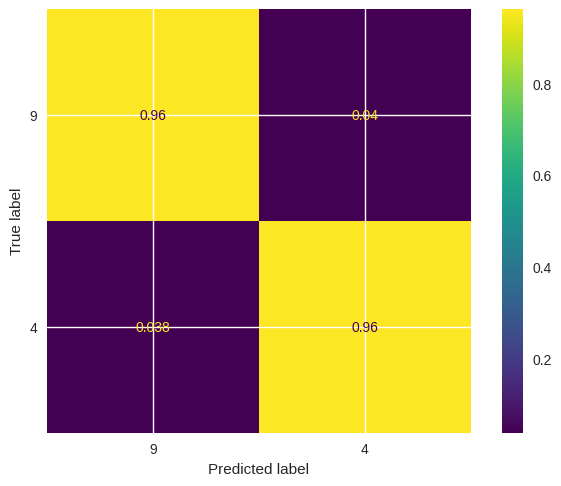

In [ ]:
# make predictions over the test set
pred = model.predict(X_test)

# display the base classifier's score
acc = accuracy_score(y_test, pred, normalize=True)
print(f'Accuracy: {acc}')

# classifier's performance using the confusion matrix
cm = confusion_matrix(y_test, pred, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=['9', '4'])
disp.plot()

In [ ]:
# displaying the classification report for the base classifier
cr = classification_report(y_test, pred, labels=model.classes_, target_names=['9', '4'])
print(cr)

              precision    recall  f1-score   support

           9       0.96      0.96      0.96       500
           4       0.96      0.96      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



As we can observe, `the baseline model has performed very well despite the small amount of examples (1000), providing an accuracy of 96%`. Can we do better? We're going to conduct a hyper-parameter tuning to seek for a better model parameter setup for our classifier. The next section invokes an exhaustive search over given hyper-parameters' domains.

<a name="partb2"></a>
> ## Hyper-parameter Tuning

In [ ]:
# setting up the hyper-parameters' domains we want to examine for our quest
param = [{'eps': [0.001, 0.005], 'tol': [0.001, 0.005]}]

# deploying the environment for our quest
clf = GridSearchCV(estimator=SMO(C=0.1), param_grid=param, cv=5, scoring='f1', n_jobs=-1, verbose=4)

In [ ]:
clf.fit(X_train[:1000, :], y_train[:1000])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=SMO(C=0.1), n_jobs=-1,
             param_grid=[{'eps': [0.001, 0.005], 'tol': [0.001, 0.005]}],
             scoring='f1', verbose=4)

In [ ]:
print(f'Best hyper-parameter setting found: {clf.best_params_}\n')
print(f'Best accuracy performance conducted: {clf.best_score_:.4f}')

Best hyper-parameter setting found: {'eps': 0.001, 'tol': 0.005}

Best accuracy performance conducted: 0.9580


As we can observe, after tuning under specific hyper-parameters domains; `we don't get better results than the baseline`, but we're going to `try the specified configuration using a larger training size`.

<a name="partb3"></a>
>## Tuned Classifier Implementation

In [ ]:
# setting up the classifier using the parameters we've found
tuned_clf = SMO(C=0.1)
tuned_clf.set_params(**clf.best_params_)
tuned_clf.get_params(deep=True)

{'C': 0.1, 'eps': 0.001, 'max_iter': 30, 'tol': 0.005}

In [ ]:
# fitting the data
tuned_clf.fit(X_train, y_train)

SMO(C=0.1, eps=0.001, tol=0.005)

Accuracy: 0.973


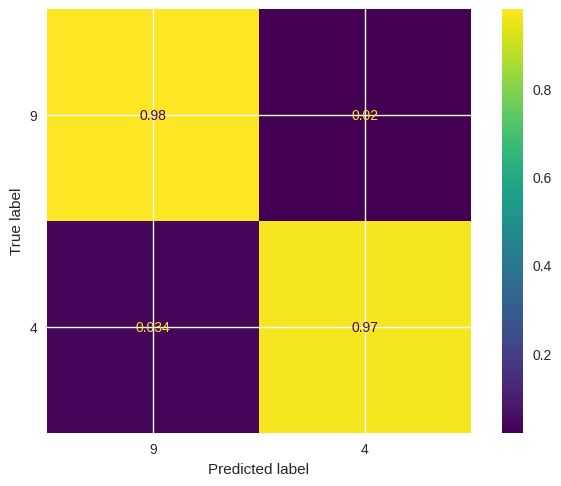

In [ ]:
# make predictions over the test set
pred_tuned = tuned_clf.predict(X_test)

# display the tuned classifier's score
acc_tuned = accuracy_score(y_test, pred_tuned, normalize=True)
print(f'Accuracy: {acc_tuned}')

# classifier's performance using the confusion matrix
cm_tuned = confusion_matrix(y_test, pred_tuned, normalize='true')
disp_tuned = ConfusionMatrixDisplay(cm_tuned, display_labels=['9', '4'])
disp_tuned.plot()

In [ ]:
# presenting the classification report
cr_tuned = classification_report(y_test, pred_tuned, labels=model.classes_, target_names=['9', '4'])
print(cr_tuned)

              precision    recall  f1-score   support

           9       0.97      0.98      0.97       500
           4       0.98      0.97      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



As we observe, `the classifier performs better using the tuned configuration` giving us a `score over 97%`.

<a name="partc"></a>
# <font color='red'>**PART C**</font> (SMO Performance wrt Training Size)

In this section, we're going to present how our tuned classifier performs over time wrt train sizes. To do that, we're going to use the accuracy metric and display the classifier's learning curve.

In [ ]:
def EvalClf(X_tr, X_te, y_tr, y_te, param):
  '''
  USAGE:  to present the learning curves of the model wrt accuracy
  TODO:
        1.  create proportional example sizes to feed the model
        2.  iterate through the example sizes:
            * create the classifier using the tuned hyper-parameters
            * fit our data
            * make predictions wrt the train & test sets
            * evaluate the classifier's accuracy using the train set
            * evaluate the classifier's accuracy using the test set
            * store each result
        3.  return findings to the user
  INPUT:
        A_tr : the train set examples
        A_te : the test set examples
        y_tr : the train set ground truth
        y_te : the test set ground truth
  OUTPUT:
        the train & test accuracies wrt train sizes
  '''
  # stating the train sizes to make our estimation.
  # here we divide the train set into 6 training sizes including the total set size
  train_sizes = np.linspace(1000, len(y_tr), 6, endpoint=True, dtype=np.int32)
  print(f'Train sizes to challenge accuracy:\n{train_sizes}\n')

  acc_train = [] # accuracy storage for train set
  acc_test = [] # accuracy storage for test set

  # make accuracy estimations wrt size
  for i in train_sizes:
    st = time.time()
    print(f'Train size: {i}')
    model_x = SMO(C=0.1)
    model_x.set_params(**param)
    model_x.fit(X_tr[:i, :], y_tr[:i]) # fitting the model
    ytr_pred = model_x.predict(X_tr[:i, :])  # make predictions based on train set

    acc_tr = accuracy_score(y_tr[:i], ytr_pred) # estimating the accuracy
    acc_train.append(acc_tr) # store result
    print(f'\tTrain accuracy: {acc_tr:.4f}')

    #--------------------------- test set --------------------------------
    yte_pred = model_x.predict(X_te) # make predictions based on test set

    acc_te = accuracy_score(y_te, yte_pred) # estimating the accuracy
    acc_test.append(acc_te) # store result
    print(f'\tTest accuracy: {acc_te:.4f}')
    duration = time.time() - st
    print(f'\tProcess Duration: {duration:.4f} secs')

  return acc_train, acc_test, train_sizes

In [ ]:
# THIS FUNCTION IS NO DIFFERENT THAN THE PREVIOUS ONE; IT IS USED TO GATHER MORE DATA TO DISPLAY
# THE DIFFERENCE IS FOCUSED ON THE TRAINING SIZES WE USE

def EvalClf2(X_tr, X_te, y_tr, y_te, param):
  train_sizes = [50, 250, 500, 750] # focusing on spcific training sizes
  print(f'Train sizes to challenge accuracy:\n{train_sizes}\n')

  acc_train = [] # accuracy storage for train set
  acc_test = [] # accuracy storage for test set

  # make accuracy estimations wrt size
  for i in train_sizes:
    st = time.time()
    print(f'Train size: {i}')
    model_x = SMO(C=0.1)
    model_x.set_params(**param)
    model_x.fit(X_tr[:i, :], y_tr[:i]) # fitting the model
    ytr_pred = model_x.predict(X_tr[:i, :])  # make predictions based on train set

    acc_tr = accuracy_score(y_tr[:i], ytr_pred) # estimating the accuracy
    acc_train.append(acc_tr) # store result
    print(f'\tTrain accuracy: {acc_tr:.4f}')

    #--------------------------- test set --------------------------------
    yte_pred = model_x.predict(X_te) # make predictions based on test set

    acc_te = accuracy_score(y_te, yte_pred) # estimating the accuracy
    acc_test.append(acc_te) # store result
    print(f'\tTest accuracy: {acc_te:.4f}')
    duration = time.time() - st
    print(f'\tProcess Duration: {duration:.4f} secs')

  return acc_train, acc_test, train_sizes

In [ ]:
def PlotCurves(acc_train, acc_test, trainSizes):
  '''
    USAGE:  to present the learning curves of the model wrt accuracy
    TODO:
          1.  create the workspace
          2.  create the x-axis
          3.  implement curvy lines
          3.  plot accuracy per size
    INPUT:
          acc_train  : train set accuracy wrt train-size
          acc_test   : test set accuracy wrt train-size
          trainSizes : the train sizes
    OUTPUT:
          the learning curves
  '''
  # plotting space configuration
  fig, ax = plt.subplots(1, 1, figsize=(15, 4))

  # curvy lines code
  ts = np.linspace(trainSizes.min(), trainSizes.max(), 100)

  spl_tr = make_interp_spline(trainSizes, acc_train, k=2)
  y_smooth_tr = spl_tr(ts)

  spl_te = make_interp_spline(trainSizes, acc_test, k=2)
  y_smooth_te = spl_te(ts)

  # lines plotting
  ax.plot(ts, y_smooth_tr, 'r', label='train')
  ax.plot(ts, y_smooth_te, 'b', label='test')

  # formating the plot
  ax.set_xlabel('\nTrain Sizes', fontsize = 15)
  ax.set_ylabel('accuracy\n', fontsize = 15)
  ax.set_title('Accuracy per Train Size\n', fontsize = 20)
  ax.legend(loc='lower right')
  ax.set_xticks(trainSizes)

In [ ]:
# getting performance over a specified training size
acc_tr0, acc_te0, tr_sz0 = EvalClf2(X_train, X_test, y_train, y_test, clf.best_params_)

Train sizes to challenge accuracy:
[50, 250, 500, 750]

Train size: 50
	Train accuracy: 1.0000
	Test accuracy: 0.8560
	Process Duration: 0.4264 secs
Train size: 250
	Train accuracy: 1.0000
	Test accuracy: 0.9210
	Process Duration: 20.0297 secs
Train size: 500
	Train accuracy: 1.0000
	Test accuracy: 0.9550
	Process Duration: 79.0563 secs
Train size: 750
	Train accuracy: 0.9987
	Test accuracy: 0.9590
	Process Duration: 146.0881 secs


In [ ]:
# perform evaluation of the classifier wrt train size
acc_tr, acc_te, tr_sz = EvalClf(X_train, X_test, y_train, y_test, clf.best_params_)

Train sizes to challenge accuracy:
[1000 2000 3000 4000 5000 6000]

Train size: 1000
	Train accuracy: 1.0000
	Test accuracy: 0.9560
	Process Duration: 373.2597 secs
Train size: 2000
	Train accuracy: 0.9995
	Test accuracy: 0.9670
	Process Duration: 1060.5894 secs
Train size: 3000
	Train accuracy: 0.9987
	Test accuracy: 0.9650
	Process Duration: 2005.6638 secs
Train size: 4000
	Train accuracy: 0.9985
	Test accuracy: 0.9680
	Process Duration: 3073.0500 secs
Train size: 5000
	Train accuracy: 0.9986
	Test accuracy: 0.9730
	Process Duration: 4394.3416 secs
Train size: 6000
	Train accuracy: 0.9985
	Test accuracy: 0.9730
	Process Duration: 6454.6857 secs


In [ ]:
# merging the results to proceed with ploting the curves
acc_tr_x = np.array([*acc_tr0, *acc_tr])
acc_te_x = np.array([*acc_te0, *acc_te])
tr_sz_x = np.array([*tr_sz0, *tr_sz])
tr_sz_x

array([  50,  250,  500,  750, 1000, 2000, 3000, 4000, 5000, 6000])

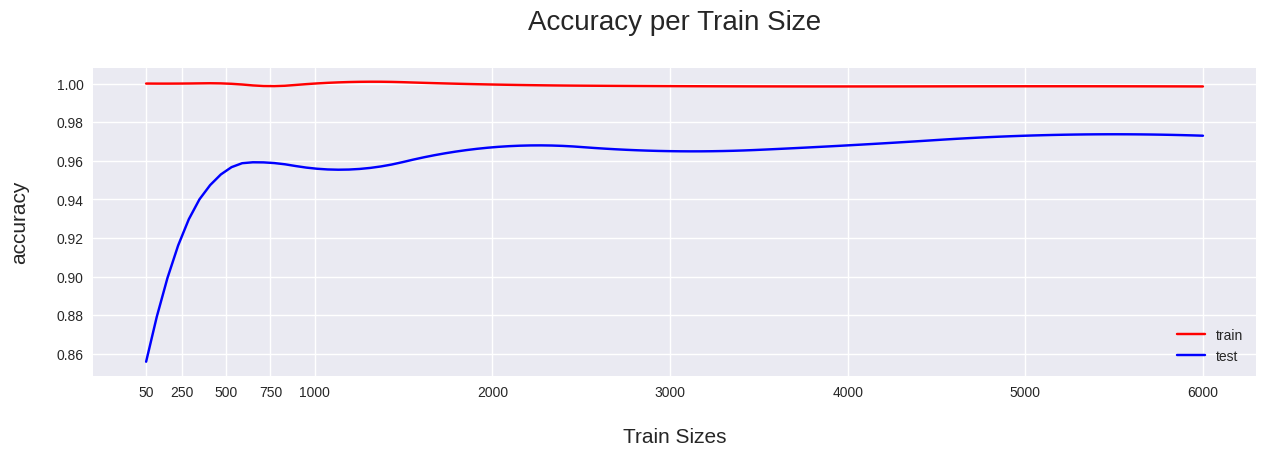

In [ ]:
# plot the learning curves of the train and test sets wrt train sizes
PlotCurves(acc_tr_x, acc_te_x, tr_sz_x)

As we can observe our classifier `starts to converge approximately at the train size 4500`. Further more, the hyper-tuning we conducted earlier gave us a slight `better accuracy than the base classifier` we started with.